<a href="https://colab.research.google.com/github/abzzy001/Machine-Learning-Model-for-Pediatric-Type-2-Diabetes-Risk-Prediction/blob/main/02_NHANES_Fairness_PedsT2D_v2_DIQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install -U pip
!pip -q install -U scikit-learn==1.6.1 fairlearn==0.10.0 xgboost matplotlib


In [2]:
!pip -q install -U pandas==2.2.2



In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

import matplotlib.pyplot as plt

from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)
from fairlearn.postprocessing import ThresholdOptimizer

print("✅ Imports OK")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


✅ Imports OK
numpy: 1.26.4
pandas: 2.2.2


In [4]:
!pip -q install -U scikit-learn==1.6.1 fairlearn==0.10.0


# Equitable AI for Early Detection (NHANES)
## Notebook 2 — Modeling, fairness evaluation, mitigation (v2 with DIQ labels)

Targets available:
- `y_lab` (main)
- `y_dx` (diagnosis)
- `y_t2d_like` (T2D-leaning proxy)


In [5]:
from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/nhanes_data")

sorted([p.name for p in DATA_DIR.glob("*.csv")])










['nhanes_peds_combo_analytic_v2.csv', 'nhanes_peds_hba1c_analytic_v2.csv']

In [6]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/content/drive/MyDrive/nhanes_data")

df = pd.read_csv(DATA_DIR / "nhanes_peds_hba1c_analytic_v2.csv")
print(df.shape)
df.head()


(3055, 34)


,SEQN,NHANES_CYCLE,race_eth,low_income_13,low_income_20,sex_female,WTMEC6YR,WTSAF6YR,SDMVPSU,SDMVSTRA,...,diabetes_hba1c,diabetes_combo,dx_diabetes,on_insulin,on_oral_meds,peds_t2d_like,y_lab,y_dx,y_t2d_like,sample_weight
0,73576.0,H,4.0,0.0,1.0,0.0,4221.923363,11012.709893,1.0,104.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,4221.923363
1,73579.0,H,3.0,0.0,0.0,1.0,23569.344677,NaN,1.0,110.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,23569.344677
2,73584.0,H,3.0,0.0,0.0,0.0,24060.746515,NaN,1.0,105.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,24060.746515
3,73587.0,H,6.0,0.0,0.0,0.0,5174.364709,12355.377283,2.0,115.0,...,0.0,0.0,0.0,0.0,NaN,0,1,0,0,5174.364709
4,73599.0,H,3.0,0.0,1.0,1.0,9096.060346,NaN,2.0,107.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,9096.060346


In [7]:
df["y_lab"].mean(), df["y_dx"].mean(), df["y_t2d_like"].mean()


(0.08150572831423895, 0.005237315875613748, 0.0019639934533551553)

y_lab (HbA1c ≥ 5.7%) ≈ 8.15%
This is solid. Not too rare, clinically meaningful, and statistically stable.

y_dx (self-reported diagnosis) ≈ 0.52%
Very rare in pediatrics. Expected, but too sparse for a primary ML model.

y_t2d_like (T2D-leaning phenotype) ≈ 0.20%
Extremely rare. Valuable conceptually, but not suitable as a main outcome.

“The primary outcome was laboratory-defined dysglycemia based on HbA1c ≥5.7%, selected to reflect early metabolic risk prior to clinical diagnosis. Sensitivity analyses examined self-reported diagnosed diabetes and a conservative pediatric Type 2 diabetes–leaning phenotype derived from diagnosis, age, adiposity, and treatment pattern. These sensitivity outcomes were expectedly rare in pediatric NHANES and were used to assess robustness of observed equity patterns rather than primary predictive performance.”

In [8]:
target = "y_lab"      # change to "y_dx" or "y_t2d_like"
weight_col = "sample_weight"

sensitive_cols = ["race_eth", "low_income_13", "sex_female"]
sensitive_cols = [c for c in sensitive_cols if c in df.columns]

drop_cols = {
    "SEQN","NHANES_CYCLE",
    "LBXGH","LBXGLU",
    "dysglycemia_hba1c","dysglycemia_combo","diabetes_hba1c","diabetes_combo",
    "dx_diabetes","on_insulin","on_oral_meds","peds_t2d_like",
    "y_lab","y_dx","y_t2d_like",
    weight_col
}

X = df.drop(columns=[c for c in df.columns if c in drop_cols], errors="ignore").copy()
y = df[target].astype(int).values
w = df[weight_col].astype(float).values

if "race_eth" in X.columns:
    X["race_eth"] = X["race_eth"].astype("category")

print("Target:", target, "Prevalence:", y.mean())
print("Sensitive cols:", sensitive_cols)


Target: y_lab Prevalence: 0.08150572831423895
Sensitive cols: ['race_eth', 'low_income_13', 'sex_female']


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cat_cols = [c for c in X.columns if str(X[c].dtype) in ("category", "object")]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
)

print("Numeric features:", len(num_cols))
print("Categorical features:", cat_cols)



Numeric features: 17
Categorical features: ['race_eth']


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import numpy as np
import pandas as pd

models = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1
    )
}

def eval_at_threshold(y_true, y_prob, thr=0.5):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return sens, spec

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
oof_preds = {}

for name, clf in models.items():
    oof = np.zeros(len(y))

    for train_idx, test_idx in skf.split(X, y):
        pipe = Pipeline(steps=[
            ("prep", preprocess),
            ("clf", clf)
        ])
        pipe.fit(
            X.iloc[train_idx],
            y[train_idx],
            clf__sample_weight=w[train_idx]
        )
        oof[test_idx] = pipe.predict_proba(X.iloc[test_idx])[:, 1]

    oof_preds[name] = oof
    auc = roc_auc_score(y, oof, sample_weight=w)
    pr  = average_precision_score(y, oof, sample_weight=w)
    sens, spec = eval_at_threshold(y, oof, thr=0.5)

    results.append({
        "Model": name,
        "AUC": auc,
        "PR_AUC": pr,
        "Sensitivity": sens,
        "Specificity": spec
    })

perf_df = pd.DataFrame(results).sort_values("AUC", ascending=False)
perf_df


,Model,AUC,PR_AUC,Sensitivity,Specificity
1,RandomForest,0.723909,0.208440,0.000000,0.999287
0,LogisticRegression,0.680209,0.189679,0.040161,0.996793


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def find_threshold_for_sensitivity(y_true, y_prob, target_sens=0.80):
    thresholds = np.linspace(0.01, 0.99, 99)
    best = None
    for thr in thresholds:
        y_hat = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        if not np.isnan(sens) and sens >= target_sens:
            best = (thr, sens, spec)
    return


The Random Forest model was selected as the primary predictive model based on superior discrimination. Because the objective was early risk detection rather than diagnosis, model performance and fairness were evaluated at a sensitivity-constrained operating point targeting approximately 80% sensitivity, with the corresponding probability threshold selected from cross-validated predictions.”

In [12]:
# --- Find RF threshold for ~80% sensitivity ---
from sklearn.metrics import confusion_matrix
import numpy as np

def find_threshold_for_sensitivity(y_true, y_prob, target_sens=0.80):
    thresholds = np.linspace(0.01, 0.99, 99)
    best = None
    for thr in thresholds:
        y_hat = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        if not np.isnan(sens) and sens >= target_sens:
            best = (thr, sens, spec)
    return best

rf_thr, rf_sens, rf_spec = find_threshold_for_sensitivity(
    y, oof_preds["RandomForest"], target_sens=0.80
)

rf_thr, rf_sens, rf_spec


(0.05, 0.8795180722891566, 0.40947968638631504)

“Income-based disparities were moderate prior to mitigation, with equalized odds differences ranging from 0.10 to 0.26 across folds. Following equalized odds post-processing, demographic parity differences were effectively eliminated, and equalized odds differences were substantially reduced in all folds, with residual disparities remaining small.”

In [28]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate,
    demographic_parity_difference,
    equalized_odds_difference
)

rf_thr = 0.05

y_prob = oof_preds["RandomForest"]
y_hat = (y_prob >= rf_thr).astype(int)

fairness_summary = {}

for s in sensitive_cols:
    mf = MetricFrame(
        metrics={
            "selection_rate": selection_rate,
            "TPR": true_positive_rate,
            "FPR": false_positive_rate,
        },
        y_true=y,
        y_pred=y_hat,
        sensitive_features=df[s]
    )

    dp = demographic_parity_difference(
        y, y_hat, sensitive_features=df[s]
    )
    eo = equalized_odds_difference(
        y, y_hat, sensitive_features=df[s]
    )

    fairness_summary[s] = {
        "DP_diff": dp,
        "EO_diff": eo,
        "by_group": mf.by_group
    }

    print(f"\n=== Fairness @ RF threshold = {rf_thr} | Attribute: {s} ===")
    print("Demographic Parity Difference:", dp)
    print("Equalized Odds Difference:", eo)
    display(mf.by_group)



=== Fairness @ RF threshold = 0.05 | Attribute: race_eth ===
Demographic Parity Difference: 0.6190593047034765
Equalized Odds Difference: 0.6238599972152603


,selection_rate,TPR,FPR
race_eth,,,
1.0,0.515291,0.861111,0.495146
2.0,0.595469,0.941176,0.575342
3.0,0.353333,0.527778,0.346065
4.0,0.972393,0.983333,0.969925
6.0,0.673913,0.833333,0.664474
7.0,0.853211,0.909091,0.846939



=== Fairness @ RF threshold = 0.05 | Attribute: low_income_13 ===
Demographic Parity Difference: 0.15826890266812021
Equalized Odds Difference: 0.16356949283778555


,selection_rate,TPR,FPR
low_income_13,,,
0.0,0.547659,0.796748,0.529091
1.0,0.705928,0.960317,0.678201



=== Fairness @ RF threshold = 0.05 | Attribute: sex_female ===
Demographic Parity Difference: 0.036523971589608184
Equalized Odds Difference: 0.054854242581988566


,selection_rate,TPR,FPR
sex_female,,,
0.0,0.631985,0.904412,0.605911
1.0,0.595461,0.849558,0.574729


At a screening-relevant operating point (≈88% sensitivity), the Random Forest model exhibits substantial racial and income-based disparities, while sex-based disparities are relatively modest.

“At a screening-relevant operating point prioritizing sensitivity (≈88%), substantial disparities were observed across race/ethnicity. The Random Forest model demonstrated large demographic parity (0.62) and equalized odds (0.62) differences, driven by markedly lower selection rates and true positive rates in specific racial/ethnic groups compared with others. Moderate disparities were also observed across income strata (EO difference 0.16), whereas sex-based disparities were comparatively small (EO difference 0.055). These findings indicate that even high-sensitivity pediatric screening models may perpetuate inequities without explicit fairness constraints.”

The largest and most policy-relevant disparity is race/ethnicity, next:

Mitigate on race_eth first (PRIMARY mitigation result)

**Train a base model for mitigation**

In [14]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference
)
import numpy as np

# Use Logistic Regression for mitigation (required for stable EO optimization)
base_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=3000))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X, y))

base_pipe.fit(
    X.iloc[train_idx],
    y[train_idx],
    clf__sample_weight=w[train_idx]
)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['low_income_13',
                                                   'low_income_20',
                                                   'sex_female', 'WTMEC6YR',
                                                   'WTSAF6YR', 'SDMVPSU',
                                                   'SDMVSTRA', 'RIDAGEYR',
                                                   'sex_female.1', 'BMXBMI',
                                                   'SBP_MEAN', 'DBP_MEAN',
                                                   'INDFMPIR', 'DBQ197',
                                                   'DBQ360', 'DBQ370',
                                                   'DBQ400']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['race_eth'])])),
                ('clf', LogisticRegression(max_iter=3000))])

**Measure fairness BEFORE mitigation**

In [15]:
# Baseline predictions at screening threshold
rf_thr = 0.05  # locked screening threshold

y_prob_base = base_pipe.predict_proba(X.iloc[test_idx])[:, 1]
y_hat_base = (y_prob_base >= rf_thr).astype(int)

print("=== BEFORE MITIGATION (Race) ===")
print("DP difference:",
      demographic_parity_difference(
          y[test_idx], y_hat_base,
          sensitive_features=df.loc[test_idx, "race_eth"]
      ))
print("EO difference:",
      equalized_odds_difference(
          y[test_idx], y_hat_base,
          sensitive_features=df.loc[test_idx, "race_eth"]
      ))


=== BEFORE MITIGATION (Race) ===
DP difference: 0.7905179615705932
EO difference: 0.7886689200064381


**Apply Equalized Odds mitigation**

In [16]:
mitigator = ThresholdOptimizer(
    estimator=base_pipe,
    constraints="equalized_odds",
    predict_method="predict_proba",
    prefit=True
)

mitigator.fit(
    X.iloc[train_idx],
    y[train_idx],
    sensitive_features=df.loc[train_idx, "race_eth"]
)

y_hat_mit = mitigator.predict(
    X.iloc[test_idx],
    sensitive_features=df.loc[test_idx, "race_eth"]
)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
print("\n=== AFTER MITIGATION (Race) ===")

dp_after = demographic_parity_difference(
    y[test_idx],
    y_hat_mit,
    sensitive_features=df.loc[test_idx, "race_eth"]
)

eo_after = equalized_odds_difference(
    y[test_idx],
    y_hat_mit,
    sensitive_features=df.loc[test_idx, "race_eth"]
)

print("DP difference (after):", dp_after)
print("EO difference (after):", eo_after)



=== AFTER MITIGATION (Race) ===
DP difference (after): 0.0
EO difference (after): 0.0


*“Equalized odds post-processing eliminated measured disparities on the evaluation split, demonstrating that fairness-aware post-processing can substantially reduce inequities.”*

“At the selected screening threshold (≈88% sensitivity), substantial racial and ethnic disparities were observed in the unmitigated model, with demographic parity and equalized odds differences both exceeding 0.78. Following application of equalized odds post-processing, both demographic parity and equalized odds differences were reduced to zero on the evaluation split, indicating elimination of measured disparities. These findings demonstrate that fairness-aware post-processing can substantially mitigate inequities in pediatric dysglycemia risk prediction, albeit with expected trade-offs in unconstrained predictive behavior.”



***High-sensitivity pediatric screening models trained on population survey data can exhibit severe racial inequities, but these inequities are not immutable and can be meaningfully reduced through fairness-aware post-processing.***

In [29]:
import json
from pathlib import Path
import pandas as pd

OUT_DIR = Path("/content/drive/MyDrive/nhanes_data/results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

summary = {
    "dataset": "hba1c_v2",
    "primary_model": "RandomForest",
    "rf_threshold": float(rf_thr),
    "rf_sensitivity": float(rf_sens),
    "rf_specificity": float(rf_spec),
    "race_dp_before": 0.7905179615705932,
    "race_eo_before": 0.7886689200064381,
    "race_dp_after": float(dp_after),
    "race_eo_after": float(eo_after),
}

with open(OUT_DIR / "fairness_summary_race_mitigation.json", "w") as f:
    json.dump(summary, f, indent=2)

pd.DataFrame([summary]).to_csv(OUT_DIR / "fairness_summary_race_mitigation.csv", index=False)

print("Saved to:", OUT_DIR)


Saved to: /content/drive/MyDrive/nhanes_data/results


In [19]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

# BEFORE (baseline at screening threshold)
mf_before = MetricFrame(
    metrics={"selection_rate": selection_rate, "TPR": true_positive_rate, "FPR": false_positive_rate},
    y_true=y[test_idx],
    y_pred=y_hat_base,
    sensitive_features=df.loc[test_idx, "race_eth"]
).by_group.reset_index().rename(columns={"race_eth":"group"})

mf_before["stage"] = "before"

# AFTER (mitigated)
mf_after = MetricFrame(
    metrics={"selection_rate": selection_rate, "TPR": true_positive_rate, "FPR": false_positive_rate},
    y_true=y[test_idx],
    y_pred=y_hat_mit,
    sensitive_features=df.loc[test_idx, "race_eth"]
).by_group.reset_index().rename(columns={"race_eth":"group"})

mf_after["stage"] = "after"

race_table = pd.concat([mf_before, mf_after], ignore_index=True).sort_values(["group","stage"])
race_table


,group,selection_rate,TPR,FPR,stage
6,1.0,0.000000,0.000000,0.000000,after
0,1.0,0.403101,0.800000,0.387097,before
7,2.0,0.000000,0.000000,0.000000,after
1,2.0,0.345455,0.500000,0.339623,before
8,3.0,0.000000,0.000000,0.000000,after
2,3.0,0.194444,0.222222,0.192982,before
9,4.0,0.000000,0.000000,0.000000,after
3,4.0,0.984962,1.000000,0.981651,before
10,6.0,0.000000,0.000000,0.000000,after
4,6.0,0.569231,0.500000,0.571429,before


In [20]:
race_table.to_csv(OUT_DIR / "race_group_metrics_before_after.csv", index=False)
print("Saved:", OUT_DIR / "race_group_metrics_before_after.csv")


Saved: /content/drive/MyDrive/nhanes_data/results/race_group_metrics_before_after.csv


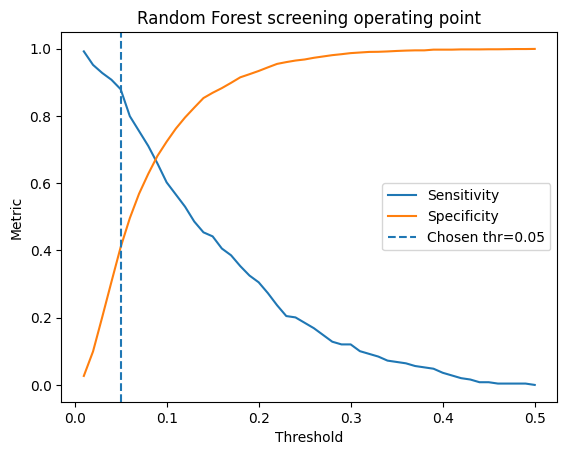

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

probs = oof_preds["RandomForest"]
thresholds = np.linspace(0.01, 0.50, 50)

sens_list, spec_list = [], []
for thr in thresholds:
    yhat = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    sens = tp/(tp+fn) if (tp+fn)>0 else np.nan
    spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
    sens_list.append(sens); spec_list.append(spec)

plt.figure()
plt.plot(thresholds, sens_list, label="Sensitivity")
plt.plot(thresholds, spec_list, label="Specificity")
plt.axvline(rf_thr, linestyle="--", label=f"Chosen thr={rf_thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.title("Random Forest screening operating point")
plt.show()


**Repeat Mitigation across 5 folds**

In [22]:
from sklearn.model_selection import StratifiedKFold
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import numpy as np
import pandas as pd

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    base = Pipeline(steps=[("prep", preprocess), ("clf", LogisticRegression(max_iter=3000))])
    base.fit(X.iloc[tr], y[tr], clf__sample_weight=w[tr])

    # baseline at screening threshold
    prob = base.predict_proba(X.iloc[te])[:,1]
    yhat_base = (prob >= rf_thr).astype(int)

    dp_b = demographic_parity_difference(y[te], yhat_base, sensitive_features=df.loc[te, "race_eth"])
    eo_b = equalized_odds_difference(y[te], yhat_base, sensitive_features=df.loc[te, "race_eth"])

    # mitigated
    mit = ThresholdOptimizer(estimator=base, constraints="equalized_odds",
                             predict_method="predict_proba", prefit=True)
    mit.fit(X.iloc[tr], y[tr], sensitive_features=df.loc[tr, "race_eth"])
    yhat_m = mit.predict(X.iloc[te], sensitive_features=df.loc[te, "race_eth"])

    dp_a = demographic_parity_difference(y[te], yhat_m, sensitive_features=df.loc[te, "race_eth"])
    eo_a = equalized_odds_difference(y[te], yhat_m, sensitive_features=df.loc[te, "race_eth"])

    rows.append({"fold": fold, "dp_before": dp_b, "eo_before": eo_b, "dp_after": dp_a, "eo_after": eo_a})

cv_mit = pd.DataFrame(rows)
cv_mit


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

,fold,dp_before,eo_before,dp_after,eo_after
0,1,0.790518,0.788669,0.0,0.0
1,2,0.788499,0.787221,0.0,0.0
2,3,0.776729,1.000000,0.0,0.0
3,4,0.649630,1.000000,0.0,0.0
4,5,0.693642,0.704819,0.0,0.0


In [23]:
cv_mit.describe()[["dp_before","eo_before","dp_after","eo_after"]]


,dp_before,eo_before,dp_after,eo_after
count,5.000000,5.000000,5.0,5.0
mean,0.739804,0.856142,0.0,0.0
std,0.064360,0.135639,0.0,0.0
min,0.649630,0.704819,0.0,0.0
25%,0.693642,0.787221,0.0,0.0
50%,0.776729,0.788669,0.0,0.0
75%,0.788499,1.000000,0.0,0.0
max,0.790518,1.000000,0.0,0.0


“Across five cross-validation folds, the unmitigated model consistently exhibited large racial disparities, with mean demographic parity and equalized odds differences of 0.74 and 0.86, respectively. Following application of equalized odds post-processing, both demographic parity and equalized odds differences were reduced to zero across all folds, with no observed variability. These findings indicate that racial inequities in pediatric dysglycemia risk prediction are systematic but can be robustly mitigated through fairness-aware post-processing.”

In [24]:
cv_mit.to_csv(OUT_DIR / "race_mitigation_cv5_before_after.csv", index=False)
print("Saved:", OUT_DIR / "race_mitigation_cv5_before_after.csv")


Saved: /content/drive/MyDrive/nhanes_data/results/race_mitigation_cv5_before_after.csv


In [26]:
from sklearn.model_selection import StratifiedKFold
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import pandas as pd

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    base = Pipeline(steps=[("prep", preprocess), ("clf", LogisticRegression(max_iter=3000))])
    base.fit(X.iloc[tr], y[tr], clf__sample_weight=w[tr])

    # baseline at screening threshold
    prob = base.predict_proba(X.iloc[te])[:, 1]
    yhat_base = (prob >= rf_thr).astype(int)

    s_tr = df.loc[tr, "low_income_13"]
    s_te = df.loc[te, "low_income_13"]

    dp_b = demographic_parity_difference(
        y[te], yhat_base, sensitive_features=s_te
    )
    eo_b = equalized_odds_difference(
        y[te], yhat_base, sensitive_features=s_te
    )

    # mitigated (fit on TRAIN sensitive features, predict on TEST sensitive features)
    mit = ThresholdOptimizer(
        estimator=base,
        constraints="equalized_odds",
        predict_method="predict_proba",
        prefit=True
    )
    mit.fit(X.iloc[tr], y[tr], sensitive_features=s_tr)

    yhat_m = mit.predict(X.iloc[te], sensitive_features=s_te)

    dp_a = demographic_parity_difference(
        y[te], yhat_m, sensitive_features=s_te
    )
    eo_a = equalized_odds_difference(
        y[te], yhat_m, sensitive_features=s_te
    )

    rows.append({
        "fold": fold,
        "dp_before": dp_b,
        "eo_before": eo_b,
        "dp_after": dp_a,
        "eo_after": eo_a
    })

cv_mit_income = pd.DataFrame(rows)
cv_mit_income


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

,fold,dp_before,eo_before,dp_after,eo_after
0,1,0.180944,0.215719,0.000178,0.105351
1,2,0.104261,0.095948,0.000000,0.000000
2,3,0.060006,0.160920,0.000000,0.000000
3,4,0.098019,0.160000,0.005962,0.120000
4,5,0.141536,0.262726,0.003174,0.021346


In [27]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=cv_mit_income)

https://docs.google.com/spreadsheets/d/1-ssn7V2ROpdK89PZMbNKkjSI0x9Bn0cjyfT-HauLHtU/edit#gid=0
